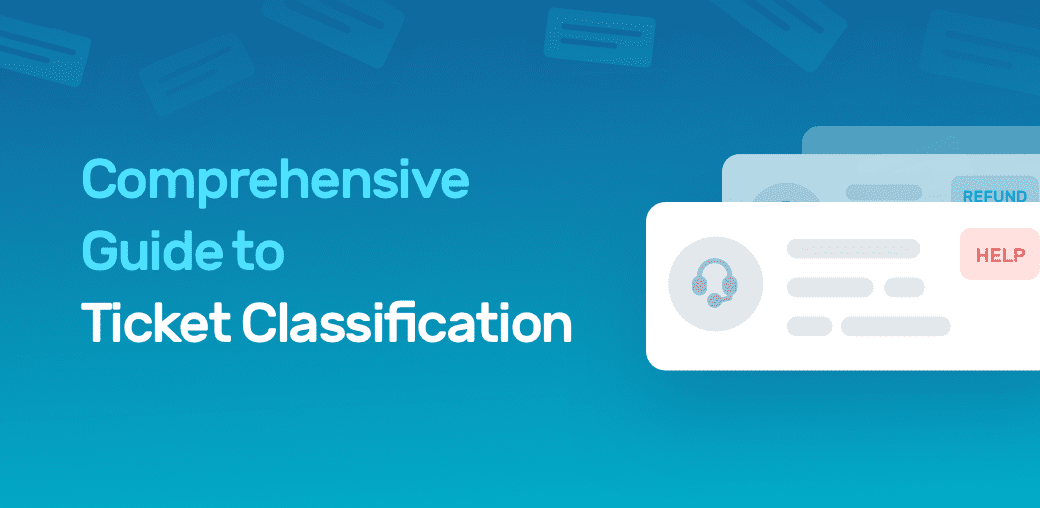

## Problem Statement 
We need to build a model that is able to classify customer complaints based on the products/services. By doing so, We can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

we will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, we need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, we will be able to map each ticket onto its respective department/category. We can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, we can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

We need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser','ner'])
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open(r"C:\Users\Rohit Chaudhary\Desktop\NLP\Ticket Classification Assignment\complaints-2021-05-14_08_16.json") 
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.head(3)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided


In [4]:
#Lets process smaller dataset initally to increase compuational speed.
# We will process full data later on
#df=df[:100]

In [5]:
df.shape

(78313, 22)

In [6]:
#printing the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [7]:
#Assigning new column name to relevant column
df.rename(columns={'_source.complaint_what_happened':"complaints"},inplace=True)

In [8]:
#Assigning nan in place of blanks in the complaints column
df.complaints=df.complaints.apply(lambda x : 'nan' if len(x)==0 else x)

In [9]:
#Removing all rows where complaints column is nan
df=df[df['complaints']!='nan']

In [10]:
df.shape

(21072, 22)

In [11]:
df.complaints.values[0]

'Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.'

## Prepare the text for topic modeling

Once we have removed all the blank complaints, we need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers



Once we have done these cleaning operations we need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [12]:
# Writing function here to clean the text and remove all the unnecessary elements.
def clean_df(text):
    # coverting text to lower case
    text=text.lower()
    #Using regex to remove text within square bracket
    Square_brackt_pattern=re.compile(r'\[.+\]')
    text=Square_brackt_pattern.sub(r'',text)
    #Using regex to remove puctuations
    punc_pattern=re.compile(r'[^\w\s]')
    text=punc_pattern.sub(r'',text)
    #Using regex to remove words with number in them
    digit_pattern=re.compile(r'\w*\d\w*')
    text=digit_pattern.sub(r'',text)
    
    return text

In [13]:
#Cleaning text
df['clean_complaints']=df['complaints'].apply(lambda x : clean_df(x) )

In [14]:
df[['complaints','clean_complaints']]

,complaints,clean_complaints
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...
...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yrs ive had ch...


In [15]:
#Writing function to Lemmatize the texts
def lemma_text(text):
    text = nlp(text)
    #applying lematization
    words = [word.lemma_ for word in text]
    #joining words
    text=' '.join(words)
    return text

In [16]:
%%time
df['lemmatized complaints']=df['clean_complaints'].apply(lambda x : lemma_text(x) )

Wall time: 5min 20s


In [17]:
#Creating dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean=df[['complaints','clean_complaints','lemmatized complaints']]

In [18]:
#Writing function to extract the POS tags 
def pos_tag(text):
  # writing code here
    text=nlp(text)
    words=[word.text for word in text if word.tag_ =='NN']
    text= " ".join(words)
    return text

In [19]:
#"complaint_POS_removed" columns shall contain lemmatized text with all the words removed 
#which have tags other than NN[tag == "NN"].

In [20]:
%%time
df_clean["complaint_POS_removed"] =df_clean['lemmatized complaints'].apply(lambda x:pos_tag(x)) 

Wall time: 6min 1s


In [21]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaints,clean_complaints,lemmatized complaints,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop debt verification statement ...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,agent anniversary date agent information order...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




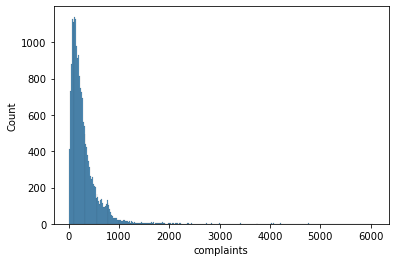

Wall time: 12min 21s


In [22]:
%%time
# Writing code here to visualise the data according to the 'Complaint' character length
sns.histplot(df_clean['complaints'].apply(lambda x : len(nlp(x))))
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

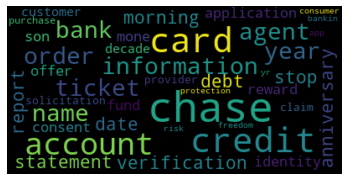

In [23]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
#WordCloud Visualizations
#Method for creating wordclouds
from PIL import Image
from wordcloud import WordCloud

text=df_clean["complaint_POS_removed"]
wordcloud = WordCloud(max_font_size=50, 
                      max_words=40, 
                      background_color="black").generate(str(text))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

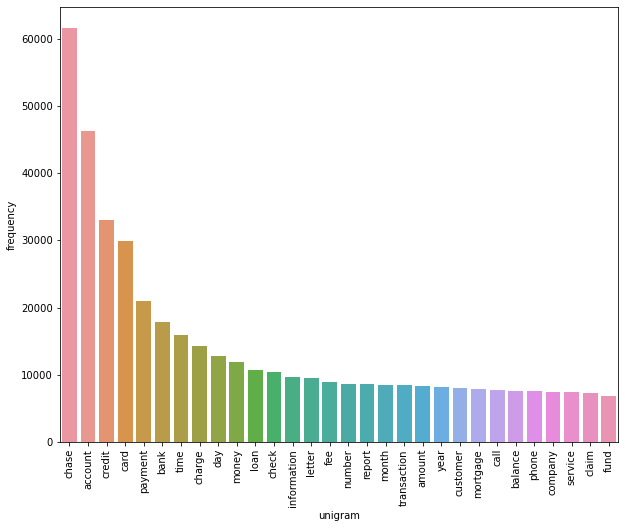

In [24]:
#Writing code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
stoplist = stopwords.words('english')
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(0,1))
# matrix of ngrams
ngrams = c_vec.fit_transform(df_clean["complaint_POS_removed"])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'unigram'})
plt.figure(figsize=(10,8))
sns.barplot(df_ngram.unigram[:30],df_ngram.frequency[:30])
plt.xticks(rotation=90)
plt.show()

In [25]:
#Printing the top 10 words in the unigram frequency
df_ngram.unigram[:10]

0      chase
1    account
2     credit
3       card
4    payment
5       bank
6       time
7     charge
8        day
9      money
Name: unigram, dtype: object

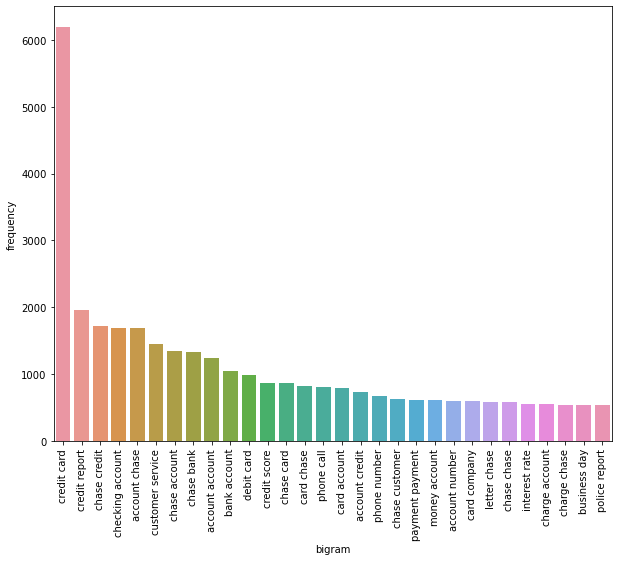

In [26]:
#Writing code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,2))
# matrix of ngrams
ngrams = c_vec.fit_transform(df_clean["complaint_POS_removed"][0:10000])#Using only 10000 as value above is gining memoryerror
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram'})
plt.figure(figsize=(10,8))
sns.barplot(df_ngram.bigram[:30],df_ngram.frequency[:30])
plt.xticks(rotation=90)
plt.show()

In [27]:
#Printing the top 10 words in the bigram frequency
df_ngram.bigram[:10]

0         credit card
1       credit report
2        chase credit
3    checking account
4       account chase
5    customer service
6       chase account
7          chase bank
8     account account
9        bank account
Name: bigram, dtype: object

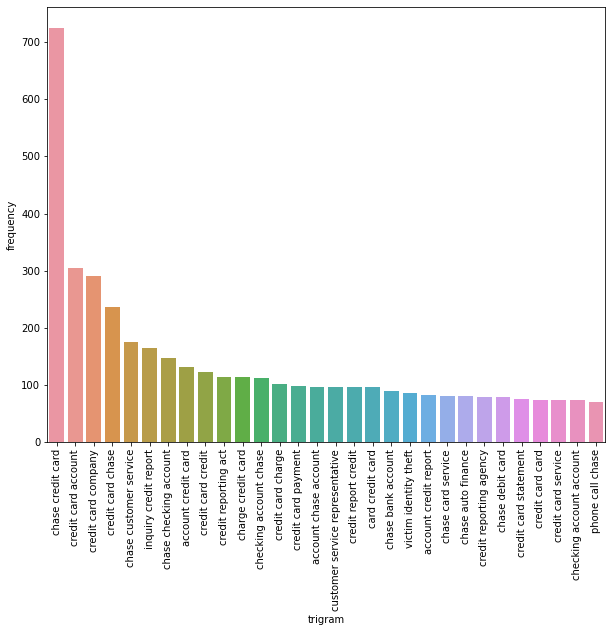

In [28]:
#Writing code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
#Writing code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(3,3))
# matrix of ngrams
ngrams = c_vec.fit_transform(df_clean["complaint_POS_removed"][0:6000])#Using only 6000 as value above is gining memoryerror
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'trigram'})
plt.figure(figsize=(10,8))
sns.barplot(df_ngram.trigram[:30],df_ngram.frequency[:30])
plt.xticks(rotation=90)
plt.show()

In [29]:
#Printing the top 10 words in the trigram frequency
df_ngram.trigram[:10]

0         chase credit card
1       credit card account
2       credit card company
3         credit card chase
4    chase customer service
5     inquiry credit report
6    chase checking account
7       account credit card
8        credit card credit
9      credit reporting act
Name: trigram, dtype: object

The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [30]:
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('xxxx','')

In [31]:
#All masked texts has been removed
df_clean.head()

,complaints,clean_complaints,lemmatized complaints,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop debt verification statement ...,morning name stop debt verification statement ...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,agent anniversary date agent information order...,agent anniversary date agent information order...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [32]:
df_clean.shape

(21072, 5)

In [33]:
#Writing code here to initialise the TfidfVectorizer 
tfidf=TfidfVectorizer(max_df=0.95, min_df=5)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [34]:
#Writing code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf_model=tfidf.fit_transform(df_clean['Complaint_clean'])

In [35]:
pd.DataFrame(tfidf_model.toarray(), columns=tfidf.get_feature_names()).head()

,aarp,abide,ability,above,abovereference,absence,absent,abuse,ac,acceleration,...,wwwchasecom,yard,year,yes,yesterday,yield,yr,zip,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task we have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [36]:
from sklearn.decomposition import NMF 

## Manual Topic Modeling
We need to do take the trial & error approach to find the best num of topics for our NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good our final topics are.

In [37]:
#Loading nmf_model with the n_components i.e 5
num_topics = 5 #the value we want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [38]:
nmf_model.fit(tfidf_model)
len(tfidf.get_feature_names())

3843

In [39]:
W = nmf_model.fit_transform(tfidf_model)  # Document-topic matrix
H = nmf_model.components_ 

In [40]:
#Printing the Top15 words for each of the topics
# Top 10 words per topic

words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,chase,fund,deposit,checking,branch,day,number,business,transaction,transfer,customer
Topic 2,credit,card,report,inquiry,chase,account,score,company,debt,information,limit,application,letter,year,reporting
Topic 3,loan,mortgage,chase,home,modification,property,year,letter,document,time,foreclosure,rate,house,sale,request
Topic 4,charge,card,chase,dispute,transaction,fee,merchant,purchase,fraud,claim,service,time,email,amount,refund
Topic 5,payment,balance,interest,month,fee,statement,amount,day,time,bill,chase,auto,date,credit,pay


## Supervised model to predict any new complaints to the relevant Topics.

We have now build the model to create the topics for each complaints.Now in the below section we will use them to classify any new complaints.

Since we will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [41]:
#Creating the best topic for each complaint in terms of integer value 0,1,2,3 & 4 as per words analysed above
topic_mapping = {
    'Topic 1': 'Bank account services',
    'Topic 2': 'Credit card / Prepaid card',
    'Topic 3': 'Mortgages/loans',
    'Topic 4': 'Theft/Dispute reporting',
    'Topic 5': 'Others'}

In [42]:
#Assigning the best topic to each of the cmplaints in Topic Column
W = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range(num_topics)])
W = W.apply(lambda x: topic_mapping.get(x.idxmax()), axis=1)

In [43]:
df_clean_final=df_clean.reset_index()

In [44]:
df_clean_final['topic']=W

In [45]:
df_clean_final['topic'].value_counts(dropna=False)

Theft/Dispute reporting       5596
Bank account services         5096
Credit card / Prepaid card    4392
Mortgages/loans               3705
Others                        2283
Name: topic, dtype: int64

In [46]:
#Dataframe with all th columns
df_clean_final.head()

,index,complaints,clean_complaints,lemmatized complaints,complaint_POS_removed,Complaint_clean,topic
0,1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,Mortgages/loans
1,2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,agent anniversary date agent information order...,agent anniversary date agent information order...,Bank account services
2,10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...,Credit card / Prepaid card
3,11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Credit card / Prepaid card
4,14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Bank account services


In [47]:
#Printing the first 5 Complaint for each of the Topics
df_clean_final_5=df_clean_final.groupby('topic').head(5)
df_clean_final_5.sort_values('topic')

,index,complaints,clean_complaints,lemmatized complaints,complaint_POS_removed,Complaint_clean,topic
12,27,I opened an account with chase bank on XXXX an...,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account code bonus term everything account dep...,account code bonus term everything account dep...,Bank account services
1,2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,agent anniversary date agent information order...,agent anniversary date agent information order...,Bank account services
4,14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Bank account services
6,17,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice chase account debit card branch custome...,notice chase account debit card branch custome...,Bank account services
10,24,mishandling of this account by Chase auto and ...,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account chase auto xxxx,mishandle account chase auto,Bank account services
2,10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...,Credit card / Prepaid card
3,11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Credit card / Prepaid card
5,15,Can you please remove inquiry,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,Credit card / Prepaid card
9,23,I have a Chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card credit report company issue,chase credit card credit report company issue,Credit card / Prepaid card
11,26,I have reached out to XXXX several times in at...,i have reached out to xxxx several times in at...,I have reach out to xxxx several time in attem...,time attempt inquiry remove creditor inquiry r...,time attempt inquiry remove creditor inquiry r...,Credit card / Prepaid card


In [48]:
#exporting dataframe to use it later 
df_clean_final.to_csv(r'C:\Users\Rohit Chaudhary\Desktop\NLP\Ticket Classification Assignment\topic_modelling_final.csv')

Now our data is labeled thus we can use Supervised Learning to predict automated ticket classification

In [49]:
#Keeping the columns"clean_complaints" & "Topic" only in the new dataframe --> training_data
#training_data=pd.read_csv(r'C:\Users\Rohit Chaudhary\Desktop\NLP\Ticket Classification Assignment\topic_modelling_final.csv')
training_data=df_clean_final[['clean_complaints','topic']]

In [50]:
#mapping the numeric topic with actual label
mapping = {
    'Bank account services': '0',
    'Credit card / Prepaid card': '1',
    'Mortgages/loans': '2',
    'Theft/Dispute reporting': '3',
    'Others': '4'}

In [51]:
#mapping numeric values to labels
training_data['topic']=training_data['topic'].map(mapping)

In [52]:
training_data.head()

,clean_complaints,topic
0,good morning my name is xxxx xxxx and i apprec...,2
1,i upgraded my xxxx xxxx card in and was told ...,0
2,chase card was reported on however fraudulent...,1
3,on while trying to book a xxxx xxxx ticket ...,1
4,my grand son give me check for i deposit it i...,0


#### Applying the supervised models on the training data created. In this process, we have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [53]:
# Lets split test train data
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test=train_test_split(training_data['clean_complaints'],training_data['topic'], test_size=0.25, 
                                                 random_state=40,stratify=training_data['topic'])

In [54]:
X_train.shape, X_test.shape,y_train.shape, y_test.shape

((15804,), (5268,), (15804,), (5268,))

In [55]:
#Writing code to get the Vector count
vectorizer=CountVectorizer()
vect_train=vectorizer.fit_transform(X_train)
vect_test=vectorizer.transform(X_test)

In [56]:
#Writing code here to transform the word vector to tf-idf
from sklearn.feature_extraction.text import TfidfTransformer
tfidf= TfidfTransformer()
tfidf_train=tfidf.fit_transform(vect_train)
tfidf_test=tfidf.transform(vect_test)

we are going try 4 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes 

**Using the required evaluation metrics we will judge the tried models and select the ones performing the best**

In [57]:
# Writing code here to build various models and evaluate them using the required metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score

Let us try all the models one by one

## 1. Naive Bayes Model

In [58]:
#instantiate Multnomial Naive bayes
nb=MultinomialNB()
#fit
nb_model=nb.fit(tfidf_train, y_train)

In [59]:
#predicting on test data
y_pred=nb_model.predict(tfidf_test)

In [60]:
#confusion matrix
cm=confusion_matrix(y_test.values,y_pred)
cm

array([[1079,   28,    4,  163,    0],
       [  81,  654,   15,  348,    0],
       [  89,   47,  674,  116,    0],
       [  81,   14,    3, 1301,    0],
       [  80,   76,   97,  307,   11]], dtype=int64)

In [61]:
print(classification_report(y_test.values,y_pred, target_names=['Bank account services','Credit card / Prepaid card',
    'Mortgages/loans',
    'Theft/Dispute reporting',
    'Others']))

                            precision    recall  f1-score   support

     Bank account services       0.77      0.85      0.80      1274
Credit card / Prepaid card       0.80      0.60      0.68      1098
           Mortgages/loans       0.85      0.73      0.78       926
   Theft/Dispute reporting       0.58      0.93      0.72      1399
                    Others       1.00      0.02      0.04       571

                  accuracy                           0.71      5268
                 macro avg       0.80      0.62      0.60      5268
              weighted avg       0.76      0.71      0.67      5268



In [62]:
#classifiaction report
cr=classification_report(y_test.values,y_pred, target_names=['Bank account services','Credit card / Prepaid card',
    'Mortgages/loans',
    'Theft/Dispute reporting',
    'Others'],output_dict=True)
df_cf_nb=pd.DataFrame(cr).transpose()
df_cf_nb

,precision,recall,f1-score,support
Bank account services,0.765248,0.846939,0.804024,1274.000000
Credit card / Prepaid card,0.798535,0.595628,0.682316,1098.000000
Mortgages/loans,0.849937,0.727862,0.784177,926.000000
Theft/Dispute reporting,0.582103,0.929950,0.716015,1399.000000
Others,1.000000,0.019264,0.037801,571.000000
accuracy,0.705961,0.705961,0.705961,0.705961
macro avg,0.799165,0.623929,0.604867,5268.000000
weighted avg,0.763880,0.705961,0.668745,5268.000000


In [63]:
metrics_df=pd.DataFrame(columns=['Log Loss','F1 Score','Cohen Kappa Score'])
def metrics_for_model(y_test,y_pred,model, model_name):
    # cohen_kappa_score
    cps=round(cohen_kappa_score(y_test,y_pred),3)
    # log loss
    loss=round(log_loss(y_test,model.predict_proba(tfidf_test)),3)
    # f1 score using macro averaging in order to consider all the f1 scores for respective classes equally 
    #and to avoid class imbalance
    f1score=round(f1_score(y_test,y_pred,average='macro'),3)
    metrics_df.loc[model_name]=[loss,f1score,cps]
    return metrics_df

In [64]:
metrics_for_model(y_test.values,y_pred,nb_model,'Naive Bayes')

,Log Loss,F1 Score,Cohen Kappa Score
Naive Bayes,0.91,0.605,0.615


## 2. Logistic Regression model

In [65]:
#instantiate Logistic Regression
log_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
#fit
log_model.fit(tfidf_train, y_train)

LogisticRegression(multi_class='multinomial')

In [66]:
#predicting on test data
y_pred=log_model.predict(tfidf_test)

In [67]:
#confusion matrix
cm=confusion_matrix(y_test.values,y_pred)
cm

array([[1208,   12,   12,   38,    4],
       [  17, 1005,    9,   62,    5],
       [  18,   23,  851,   26,    8],
       [  48,   24,   17, 1300,   10],
       [  24,   15,   30,   17,  485]], dtype=int64)

In [68]:
#classifiaction report
cr=classification_report(y_test.values,y_pred, target_names=['Bank account services','Credit card / Prepaid card',
    'Mortgages/loans',
    'Theft/Dispute reporting',
    'Others'],output_dict=True)
df_cf_nb=pd.DataFrame(cr).transpose()
df_cf_nb

,precision,recall,f1-score,support
Bank account services,0.918631,0.948195,0.933179,1274.000000
Credit card / Prepaid card,0.931418,0.915301,0.923289,1098.000000
Mortgages/loans,0.926007,0.919006,0.922493,926.000000
Theft/Dispute reporting,0.900901,0.929235,0.914849,1399.000000
Others,0.947266,0.849387,0.895660,571.000000
accuracy,0.920463,0.920463,0.920463,0.920463
macro avg,0.924844,0.912225,0.917894,5268.000000
weighted avg,0.920988,0.920463,0.920305,5268.000000


In [69]:
metrics_for_model(y_test.values,y_pred,log_model,'Logistic Regression')

,Log Loss,F1 Score,Cohen Kappa Score
Naive Bayes,0.91,0.605,0.615
Logistic Regression,0.30,0.918,0.898


## 3. Decision Tree model

In [70]:
#instantiate Decision Tree classifier
tree_model = DecisionTreeClassifier()
#fit
tree_model.fit(tfidf_train, y_train)

DecisionTreeClassifier()

In [71]:
#predicting on test data
y_pred=tree_model.predict(tfidf_test)

In [72]:
#confusion matrix
cm=confusion_matrix(y_test.values,y_pred)
cm

array([[ 978,   69,   40,  153,   34],
       [  53,  875,   31,  120,   19],
       [  43,   43,  748,   44,   48],
       [ 135,  107,   55, 1055,   47],
       [  25,   33,   44,   31,  438]], dtype=int64)

In [73]:
#classifiaction report
cr=classification_report(y_test.values,y_pred, target_names=['Bank account services','Credit card / Prepaid card',
    'Mortgages/loans',
    'Theft/Dispute reporting',
    'Others'],output_dict=True)
df_cf_nb=pd.DataFrame(cr).transpose()
df_cf_nb

,precision,recall,f1-score,support
Bank account services,0.792545,0.767661,0.779904,1274.000000
Credit card / Prepaid card,0.776398,0.796903,0.786517,1098.000000
Mortgages/loans,0.814815,0.807775,0.811280,926.000000
Theft/Dispute reporting,0.751960,0.754110,0.753034,1399.000000
Others,0.747440,0.767075,0.757131,571.000000
accuracy,0.777145,0.777145,0.777145,0.777145
macro avg,0.776631,0.778705,0.777573,5268.000000
weighted avg,0.777427,0.777145,0.777193,5268.000000


In [74]:
metrics_for_model(y_test.values,y_pred,tree_model,'Decision Tree')

,Log Loss,F1 Score,Cohen Kappa Score
Naive Bayes,0.910,0.605,0.615
Logistic Regression,0.300,0.918,0.898
Decision Tree,7.697,0.778,0.716


## 4. Random Forest model

In [75]:
#instantiate random Forestclassifier
rf_model = DecisionTreeClassifier()
#fit
rf_model.fit(tfidf_train, y_train)

DecisionTreeClassifier()

In [76]:
#predicting on test data
y_pred=rf_model.predict(tfidf_test)

In [77]:
#confusion matrix
cm=confusion_matrix(y_test.values,y_pred)
cm

array([[ 983,   66,   44,  145,   36],
       [  49,  867,   34,  126,   22],
       [  41,   43,  743,   40,   59],
       [ 140,  114,   59, 1041,   45],
       [  28,   37,   42,   31,  433]], dtype=int64)

In [78]:
#classifiaction report
cr_rf=classification_report(y_test.values,y_pred, target_names=['Bank account services','Credit card / Prepaid card',
    'Mortgages/loans',
    'Theft/Dispute reporting',
    'Others'],output_dict=True)
df_cf_rf=pd.DataFrame(cr_rf).transpose()
df_cf_rf

,precision,recall,f1-score,support
Bank account services,0.792103,0.771586,0.781710,1274.00000
Credit card / Prepaid card,0.769299,0.789617,0.779326,1098.00000
Mortgages/loans,0.805857,0.802376,0.804113,926.00000
Theft/Dispute reporting,0.752711,0.744103,0.748382,1399.00000
Others,0.727731,0.758319,0.742710,571.00000
accuracy,0.772020,0.772020,0.772020,0.77202
macro avg,0.769540,0.773200,0.771248,5268.00000
weighted avg,0.772329,0.772020,0.772073,5268.00000


In [79]:
metrics_for_model(y_test.values,y_pred,rf_model,'Random Forest')

,Log Loss,F1 Score,Cohen Kappa Score
Naive Bayes,0.910,0.605,0.615
Logistic Regression,0.300,0.918,0.898
Decision Tree,7.697,0.778,0.716
Random Forest,7.874,0.771,0.710


### Lets check Logistics Regreesion model on a random arbitrary ticket to check model accuracy

In [81]:
# defining function to implement Logistic Regression model on random ticket
def ticket_topic(ticket):
    #lets clean and lemmatize this text
    clean_ticket=clean_df(ticket) 
    #Lets lemmatize text
    clean_ticket=lemma_text(clean_ticket)
    #lets remove xxxx
    clean_ticket=clean_ticket.replace('xxxx','')
    #Count vectorizer'
    vect_ticket=vectorizer.transform([clean_ticket])
    #tfidf
    tfidf_ticket=tfidf.transform(vect_ticket)
    #predicting ticket class
    topic_ticket=log_model.predict(tfidf_ticket)
    if topic_ticket[0]=='0':
        return 'Topic of ticket is Bank account services'
    if topic_ticket[0]=='1':
        return 'Topic of ticket is Credit card / Prepaid card'
    if topic_ticket[0]=='2':
        return 'Topic of ticket is Mortgages/loans'
    if topic_ticket[0]=='3':
        return 'Topic of ticket is Theft/Dispute reporting'
    if topic_ticket[0]=='4':
        return 'Topic of ticket is Others'

In [82]:
# Lets check few random ticksts 
ticket="My account No. is XXXXXXXXXX. I'm unable to withdraw money from ATM. Please help"

In [83]:
print(ticket_topic(ticket))

Topic of ticket is Bank account services


In [84]:
ticket="I'm unable to pay my loan installment"

In [85]:
print(ticket_topic(ticket))

Topic of ticket is Mortgages/loans


In [86]:
ticket="I want to report loss of my card and i want to block same"

In [87]:
print(ticket_topic(ticket))

Topic of ticket is Credit card / Prepaid card


In [88]:
ticket="Bank has deducted xxx$ wrongly please refund same"

In [89]:
print(ticket_topic(ticket))

Topic of ticket is Theft/Dispute reporting


## Conclusion:
1. As per F1 score (~ 0.918), log loss & Cohen Kappa Score (~ 0.898) best model comes out to be Logistic Regression as brought out above.
2. We can further increase performance of model by hyperparameter tunning on all the model.